<a href="https://www.kaggle.com/code/shiwayz/differentiated-thyroid-cancer-recurrence?scriptVersionId=161516242" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [14]:
# No missing data
# Categorical features (except 'Age')
# Random Forest Accuracy: 100%
# Most important features: ['Response', 'Risk', 'N', 'T', 'Age', 'Adenopathy', 'Stage']
# Top 5 features: 100%

# IMPORT LIBRARIES

In [15]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

In [16]:
data_dir = '/kaggle/input/differentiated-thyroid-cancer-recurrence/Thyroid_Diff.csv'
data = pd.read_csv(data_dir)

# EDA

In [17]:
data.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

In [19]:
# Label Encoding 
label_encoders = {}
categorical_columns = data.select_dtypes(include=['object']).columns

for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

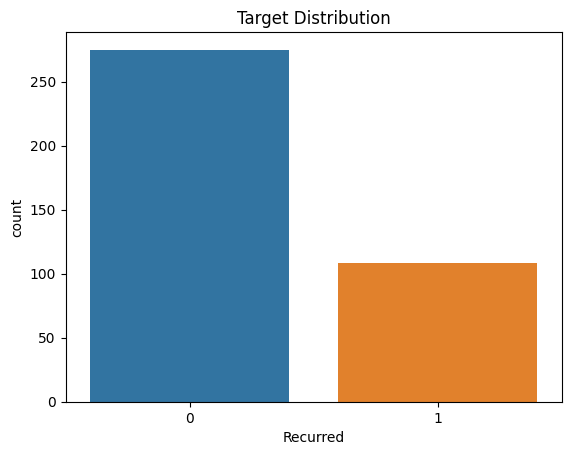

In [20]:
# Check target 
sns.countplot(data= data, x='Recurred')
plt.title(f'Target Distribution')
plt.show()

In [21]:
X = data.drop('Recurred', axis=1)
y = data['Recurred']


# MODELS

In [22]:
def train_and_evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Support Vector Machine': SVC(kernel = 'linear',
                                      random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False,
                                 max_depth = 5,
                                 eval_metric='logloss',
                                 random_state=42)
    }
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        print(f'{name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

In [23]:
train_and_evaluate_models(X, y)

Logistic Regression - Accuracy: 0.9310, F1 Score: 0.9291
Decision Tree - Accuracy: 0.9310, F1 Score: 0.9325
Random Forest - Accuracy: 1.0000, F1 Score: 1.0000
Support Vector Machine - Accuracy: 0.9655, F1 Score: 0.9646
XGBoost - Accuracy: 0.9828, F1 Score: 0.9830


# BAGGING

In [24]:
def train_and_evaluate_models_with_bagging(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    
    models = {
        #'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        #'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(),
        #'Support Vector Machine': SVC(kernel='linear', probability = True, random_state=42),
        #'LightGBM': LGBMClassifier(num_leaves =  25, max_depth = 10, random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, max_depth=5, eval_metric='logloss', random_state=42)
    }
    
    ensemble_models = [(name, model) for name, model in models.items()]
    
    ensemble = VotingClassifier(estimators=ensemble_models, voting='soft')
    
    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'Bagged Ensemble - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

    
train_and_evaluate_models_with_bagging(X, y)


Bagged Ensemble - Accuracy: 1.0000, F1 Score: 1.0000


# FEATURE IMPORTANCE

Accuracy: 1.0000 



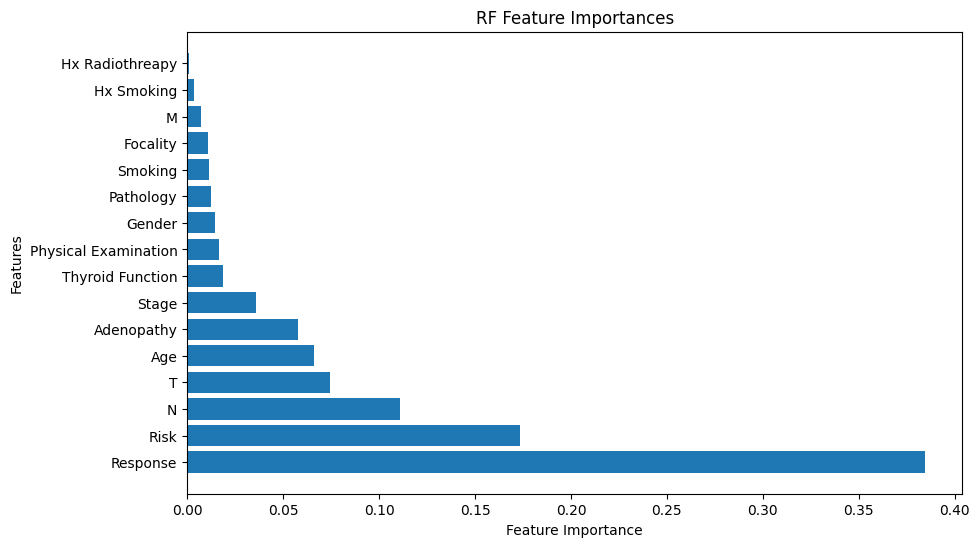

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

final_rf_model = RandomForestClassifier(random_state=42)
final_rf_model.fit(X_train, y_train)

y_pred = final_rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f} \n')

feature_importances_rf = final_rf_model.feature_importances_
sorted_features = [x for _, x in sorted(zip(feature_importances_rf, X.columns), reverse=True)]
sorted_importances = sorted(feature_importances_rf, reverse=True)

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('RF Feature Importances')
plt.show()

# USING TOP 5 FEATURES

In [31]:
selected_features = ['Response', 'Risk', 'N', 'T', 'Age', 'Adenopathy', 'Stage']
X_selected = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.15, random_state=42)

final_rf_model = RandomForestClassifier(random_state=42)
final_rf_model.fit(X_train, y_train)

y_pred = final_rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 1.0000
